# Time Series Analysis of Pokémon GO User Activity on Twitter

In [58]:
# Import graphics related libraries
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import Image
from IPython import display
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
matplotlib.rcParams['figure.figsize'] = 6,4

# other libraries
import numpy as np
import scipy as sp
import pandas as pd
import sys
import requests
import sqlite3
from datetime import datetime
import math
from sklearn import linear_model
from sklearn import metrics

# Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA



## Loading and Handling Time Series Data

In [2]:
# Loading tweet data
conn = sqlite3.connect('/users/yinagu/pokemon.sqlite')
cur = conn.cursor()

cur.execute('''SELECT created_at from hashtags''')
    
df_time = pd.DataFrame([pd.to_datetime(str(row).strip()[3:-3], 
                                      format = '%Y-%m-%d %H:%M:%S') 
                        for row in cur], columns=['time'])

In [3]:
# Convert to datatime object
df_time['time'] = pd.to_datetime(df_time['time'])

df_time = df_time.set_index(['time'])

# Groupby every hour
min_count = pd.DataFrame(df_time.groupby(pd.TimeGrouper("60Min")).size())

In [5]:
min_count.columns = ['count']
# Select the data from 2017/1/8 to 2017/1/25
min_count = min_count['2017-01-08' :'2017-01-25 19:00']
min_count.head()

,count
time,
2017-01-08 01:00:00,128
2017-01-08 02:00:00,185
2017-01-08 03:00:00,158
2017-01-08 04:00:00,193
2017-01-08 05:00:00,264


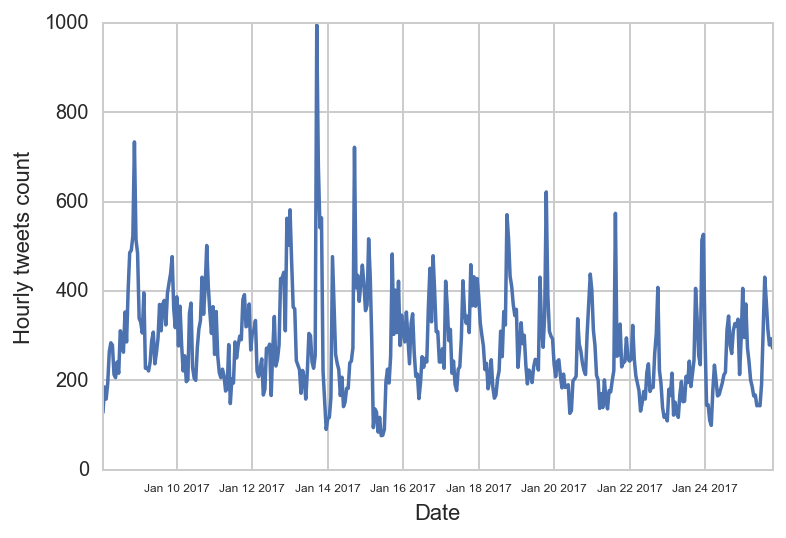

In [7]:
# Visualize a Time Series
ts = min_count['count']
plt.style.use('seaborn-whitegrid')
plt.plot(ts)
plt.xticks(fontsize=6)
plt.xlabel('Date')
plt.ylabel('Hourly tweets count')

## Check Stationarity of a Time Series

In [16]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24, center=False).mean()
    rolstd = timeseries.rolling(window=24, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(fontsize=6)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

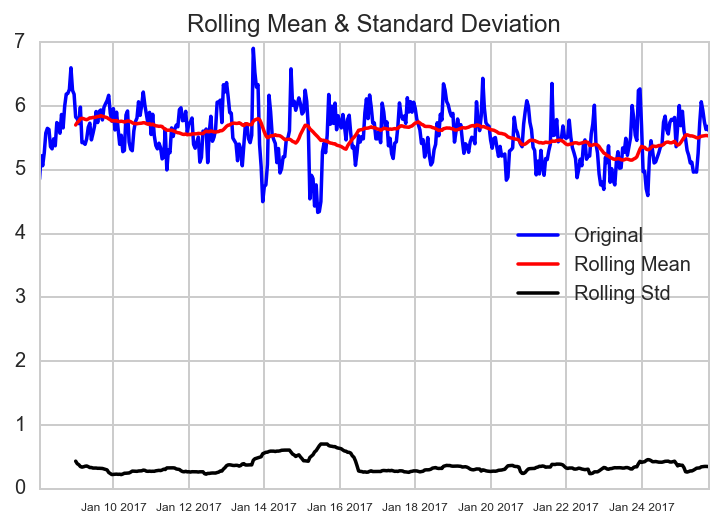

Results of Dickey-Fuller Test:
Test Statistic                -7.967795e+00
p-value                        2.834096e-12
#Lags Used                     0.000000e+00
Number of Observations Used    4.260000e+02
Critical Value (5%)           -2.868349e+00
Critical Value (1%)           -3.445794e+00
Critical Value (10%)          -2.570397e+00
dtype: float64


In [22]:
# Reduce trend by log transformation 
ts_log = ts.map(np.log)
test_stationarity(ts_log)

## Estimating & Eliminating Trend

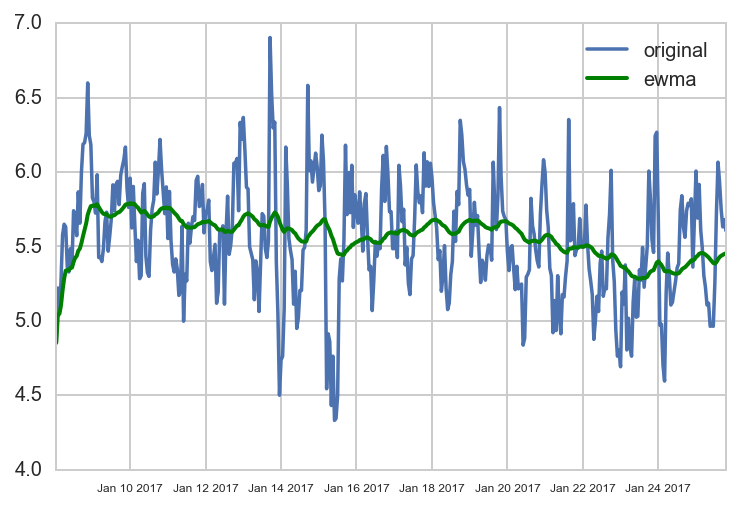

In [69]:
# Exponential Weighted Moving Average
expwighted_avg = ts_log.ewm(halflife=24).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='green', linewidth = 2)
plt.legend(['original', 'ewma'])
plt.xticks(fontsize=6)
plt.show()

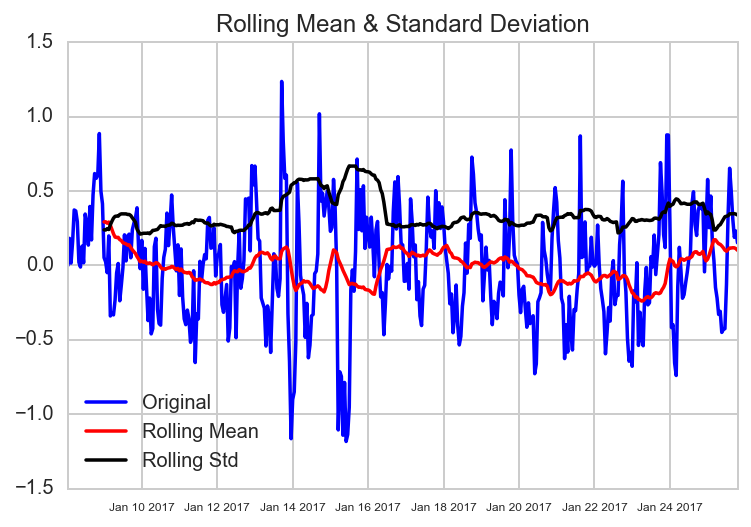

Results of Dickey-Fuller Test:
Test Statistic                -8.320234e+00
p-value                        3.589017e-13
#Lags Used                     1.100000e+01
Number of Observations Used    4.150000e+02
Critical Value (5%)           -2.868530e+00
Critical Value (1%)           -3.446206e+00
Critical Value (10%)          -2.570493e+00
dtype: float64


In [24]:
# Take the differece between original data with the EWMA to get even better stationarity
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Estimating & Eliminating Seasonality

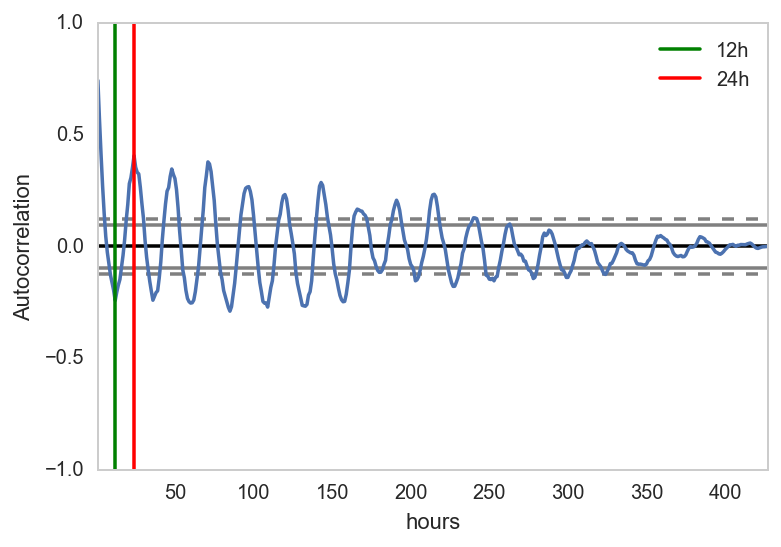

In [25]:
# Plot auto-correlation function
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(ts_log)
plt.xlabel('hours')
plt.axvline(12, color='green', label='12h')
plt.axvline(24, color='red', label='24h')
plt.legend()

## Fourier Analysis

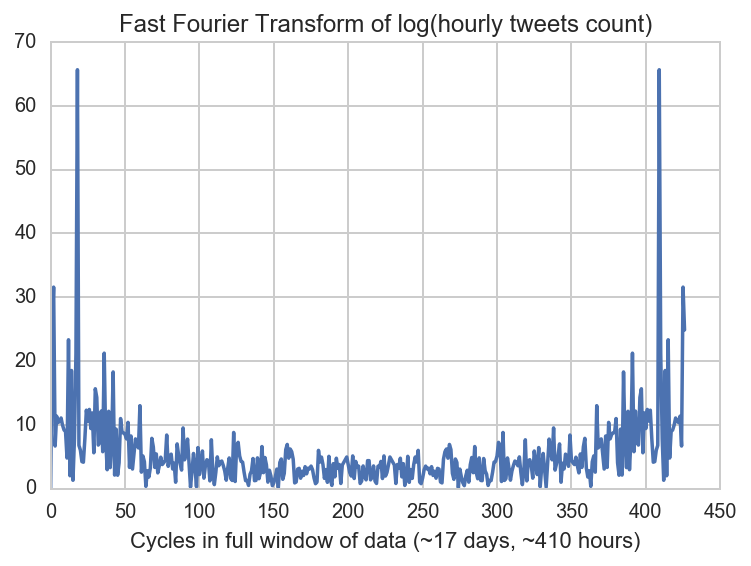

In [26]:
from scipy import fftpack

fft = fftpack.fft(ts_log - ts_log.mean())
plt.plot(np.abs(fft))
plt.title("Fast Fourier Transform of log(hourly tweets count)")
plt.xlabel("Cycles in full window of data (~17 days, ~410 hours)")

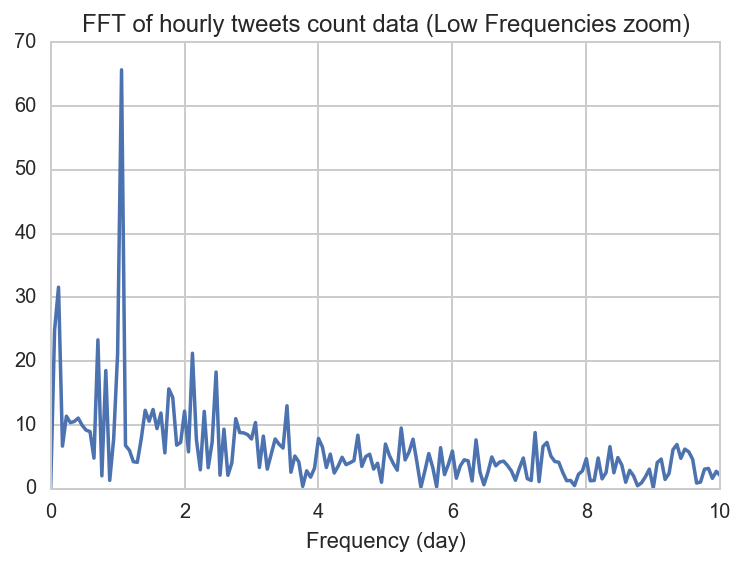

In [42]:
plt.plot(1./17 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of hourly tweets count data (Low Frequencies zoom)")
plt.xlim([0,10])
plt.xlabel('Frequency (day)')

## Seasonal Decomposition

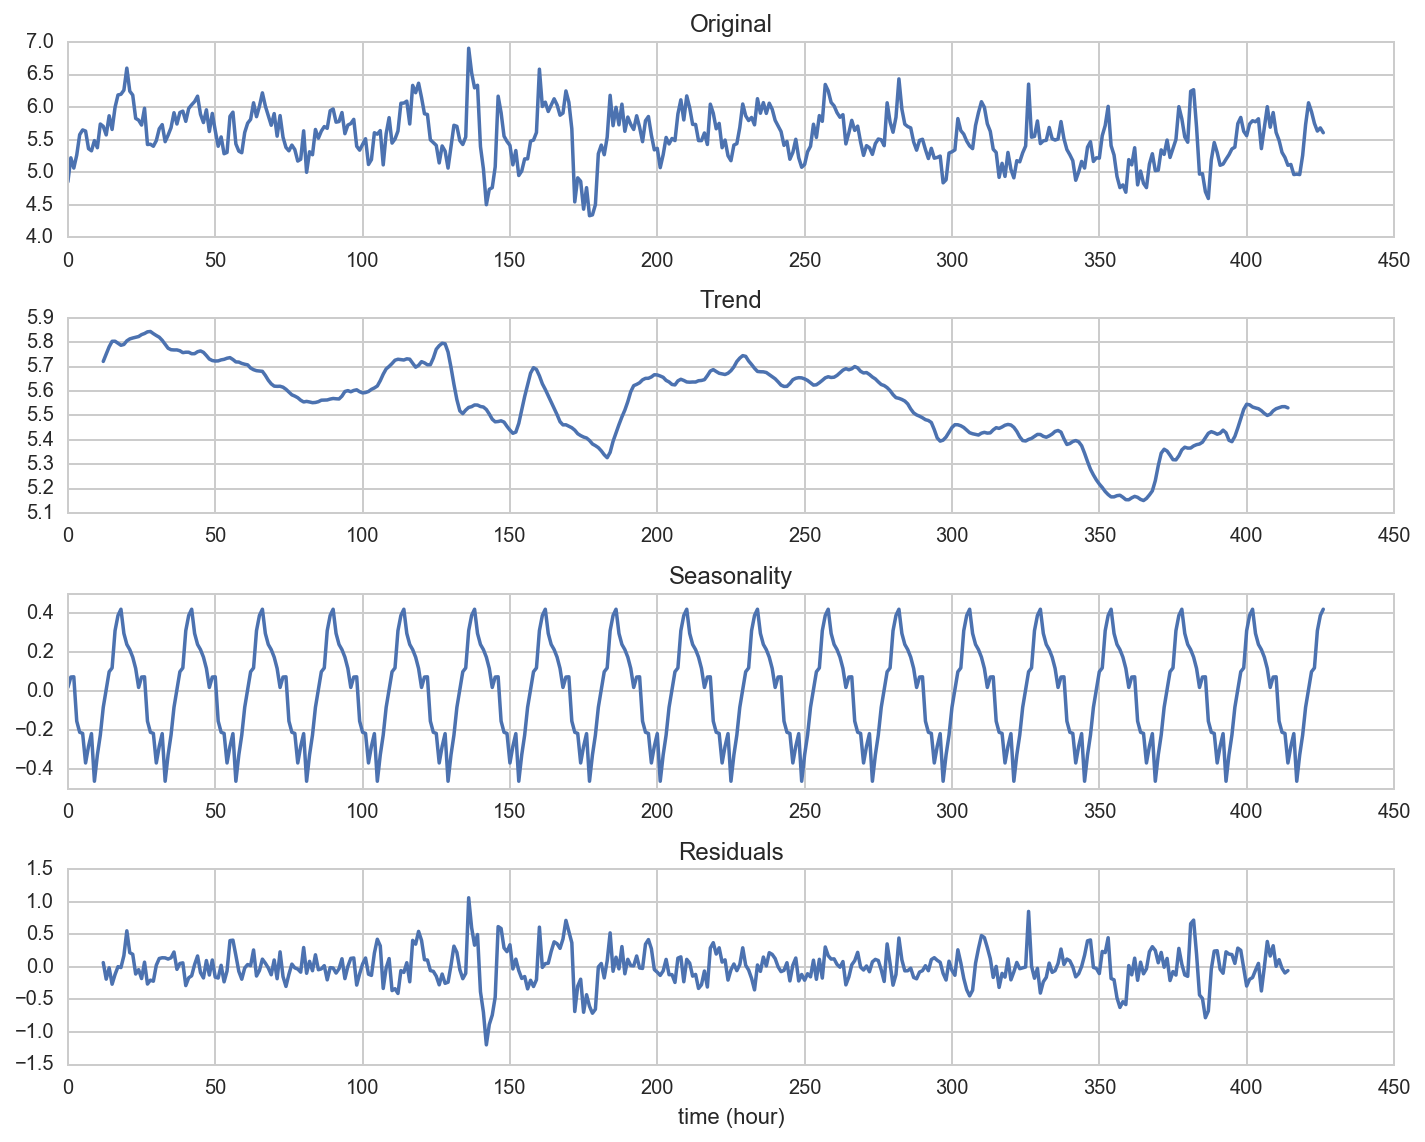

In [46]:
decomposition = seasonal_decompose(np.log(ts.values), freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize = (10,8))
plt.subplot(411)
plt.plot(np.log(ts.values), label='Original')
plt.title('Original')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.title('Trend')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.title('Seasonality')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.title('Residuals')
plt.xlabel('time (hour)')
plt.tight_layout()

## Model daily seasonality using sinusoidal function

In [34]:
df_ts = pd.DataFrame(np.vstack((ts.index.hour, ts.values)).transpose(),columns=['hour','count'])

df_ts['hour_sin'] = df_ts['hour'].map(lambda x : math.sin(2*math.pi*x/24))
df_ts['hour_cos'] = df_ts['hour'].map(lambda x : math.cos(2*math.pi*x/24))

df_ts.head()

,hour,count,hour_sin,hour_cos
0,1,128,0.258819,0.965926
1,2,185,0.500000,0.866025
2,3,158,0.707107,0.707107
3,4,193,0.866025,0.500000
4,5,264,0.965926,0.258819


In [36]:
# Split the train test sets
train = df_ts[:300]
test = df_ts[300:]
X_train = train[['hour_sin','hour_cos']]
y_train = train['count'].reshape(len(train),1)

X_test = test[['hour_sin','hour_cos']]
y_test = test['count'].reshape(len(test),1)

# Build linear regression model
lrg = linear_model.LinearRegression()

lrg.fit(X_train, y_train)
train_predict = lrg.predict(X_train)
test_predict = lrg.predict(X_test)

print metrics.mean_squared_error(y_train, train_predict)
print metrics.mean_squared_error(y_test, test_predict)

8350.60687382
10562.0985393


/Users/yinagu/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


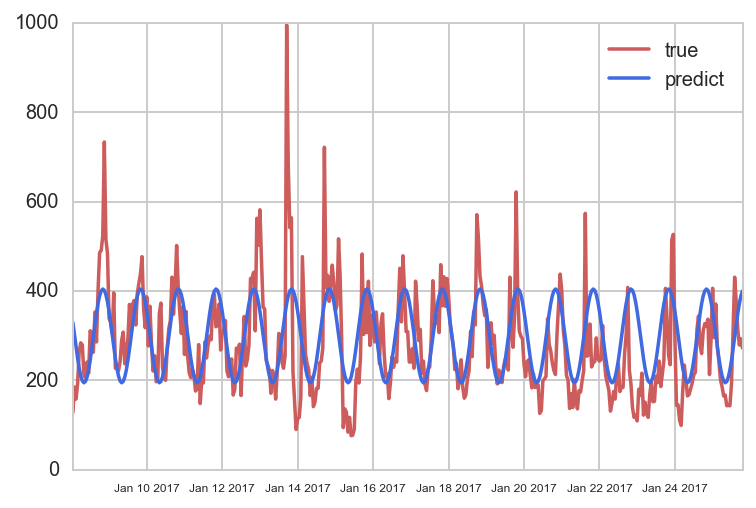

In [39]:
# Predict and visualize the result
all_predict = lrg.predict(df_ts[['hour_sin','hour_cos']])

plt.plot(ts.index, ts.values, label = 'true', color='indianred')
plt.plot(ts.index, all_predict, label = 'predict', color='royalblue')
plt.xticks(fontsize=6)
plt.legend()
plt.show()

In [40]:
# Compute mean and std of hourly tweet count of a day

df_24h = pd.DataFrame(df_ts.groupby('hour')[['count', 'hour_sin', 'hour_cos']].mean())
df_24h['std'] = df_ts.groupby('hour')['count'].std()

lrg24 = linear_model.LinearRegression()

lrg24.fit(df_24h[['hour_sin','hour_cos']], df_24h['count'])

predict = lrg24.predict(df_24h[['hour_sin','hour_cos']])

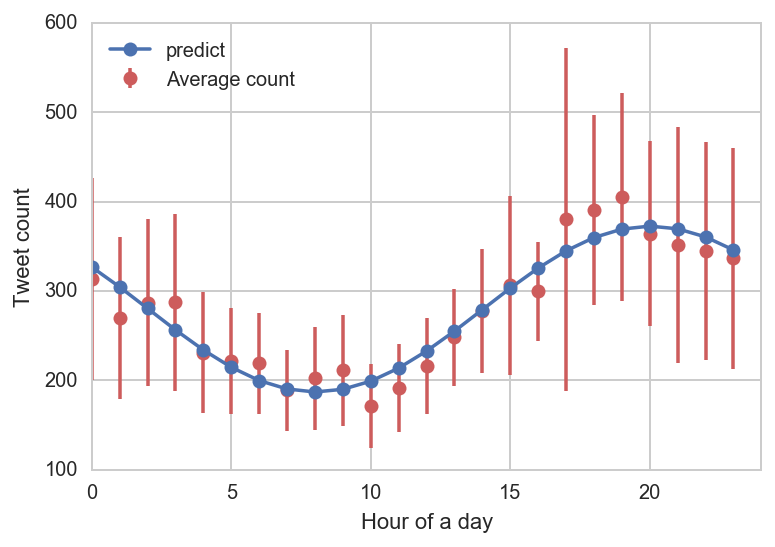

In [41]:
plt.errorbar(df_24h.index, df_24h['count'], df_24h['std'], fmt = 'o', label='Average count',color='indianred')
plt.plot(df_24h.index, predict, 'o-', label='predict')
plt.xlim(0,24)
plt.legend(loc='best')
plt.xlabel('Hour of a day')
plt.ylabel('Tweet count')

## Model differencing of time series after log transformation

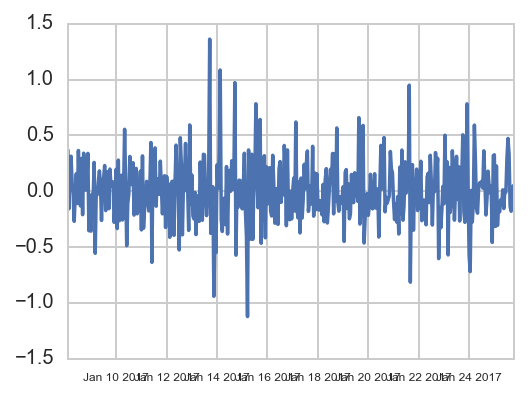

In [72]:
ts_log_diff = ts_log - ts_log.shift()

fig = plt.figure(figsize = (4,3))
plt.plot(ts_log_diff)
plt.xticks(fontsize=6)
plt.show()

## Use ACF and PACF to determine parameters for ARMA and ARIMA model

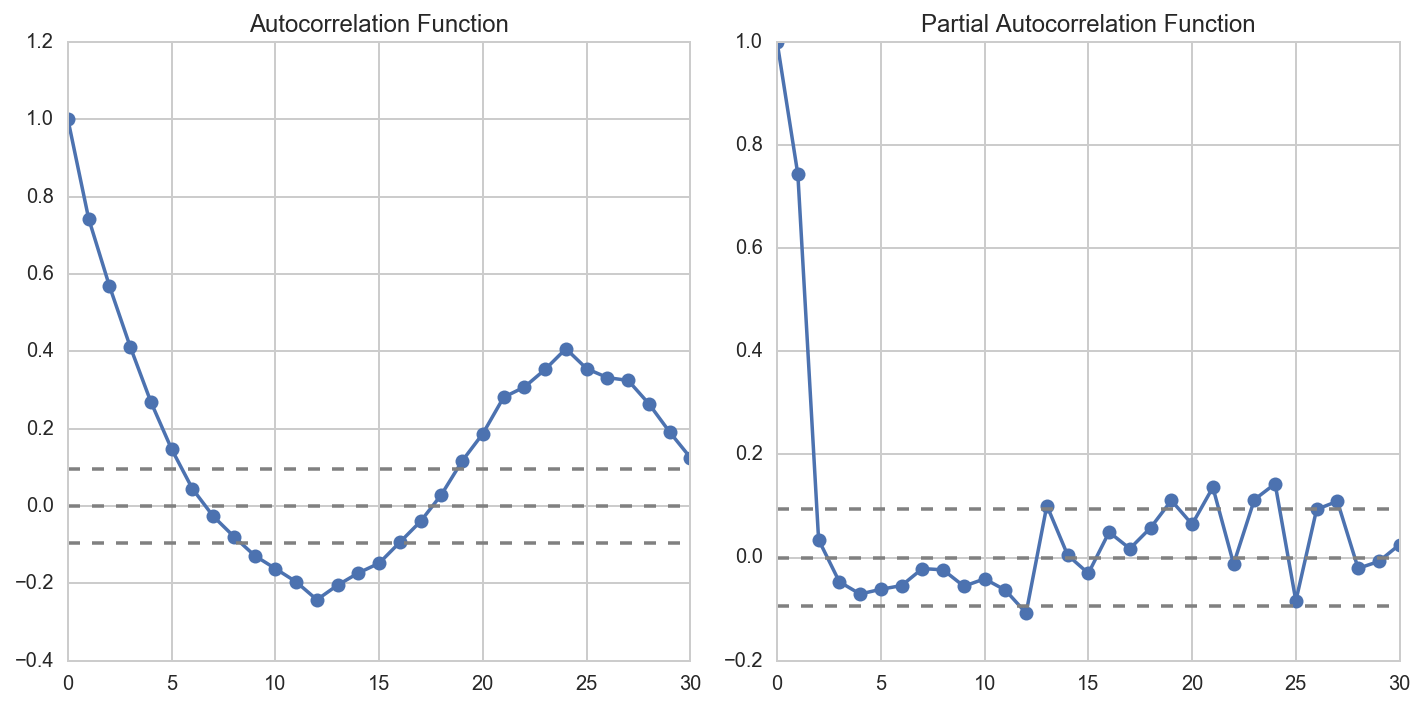

In [75]:
# Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF)

lag_acf = acf(ts_log, nlags=30)
lag_pacf = pacf(ts_log, nlags=30, method='ols')

#Plot ACF: 
plt.figure(figsize = (10, 5))
plt.subplot(121) 
plt.plot(lag_acf, 'o-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')



#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, 'o-')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

## AR Model

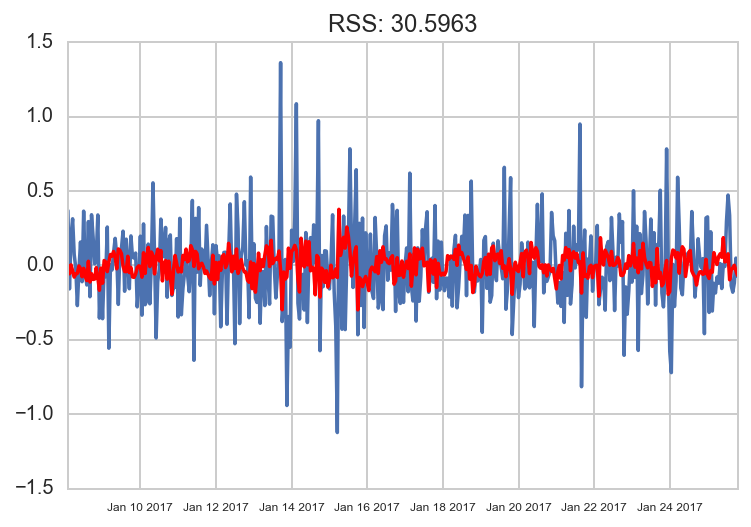

In [54]:
model = ARIMA(ts_log, order=(12, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.xticks(fontsize=6)
plt.title('RSS: %.4f'% np.nansum((results_AR.fittedvalues-ts_log_diff)**2))

## MA model

/Users/yinagu/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


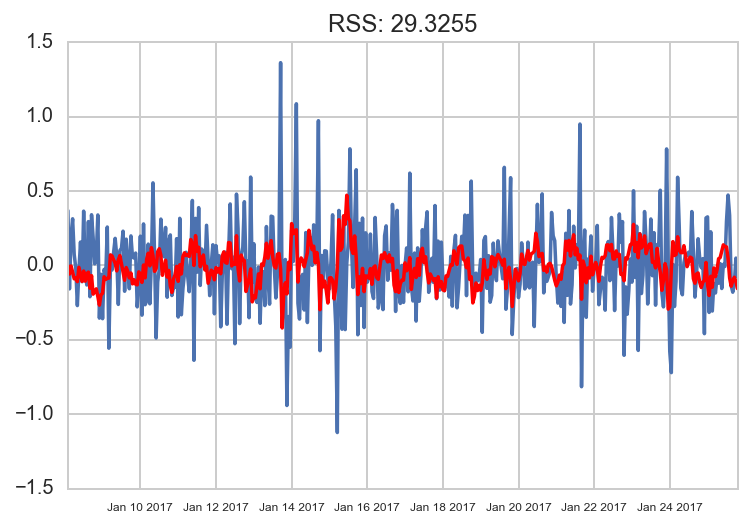

In [60]:
model = ARIMA(ts_log, order=(0, 1, 6))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.xticks(fontsize=6)
plt.title('RSS: %.4f'% np.nansum((results_MA.fittedvalues-ts_log_diff)**2))

## ARIMA model

/Users/yinagu/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


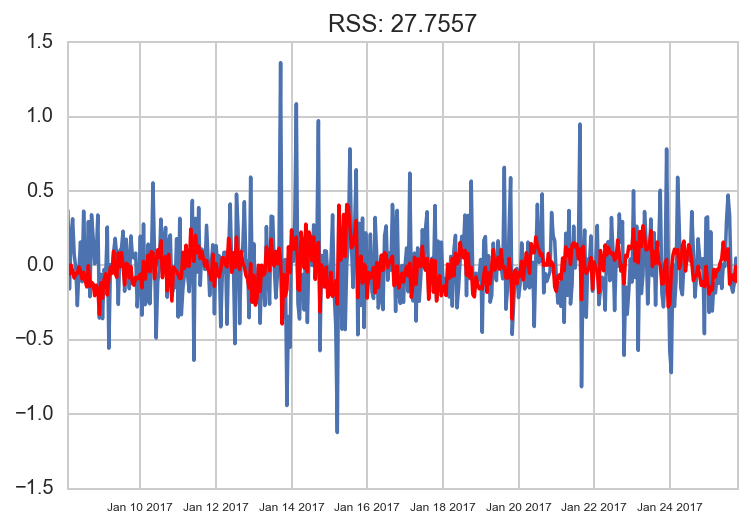

In [65]:
model = ARIMA(ts_log, order=(12, 1, 6))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.xticks(fontsize=6)
plt.title('RSS: %.4f'% np.nansum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [57]:
# Output result summary
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                  426
Model:                ARIMA(12, 1, 6)   Log Likelihood                 -23.122
Method:                       css-mle   S.D. of innovations              0.254
Date:                Sun, 12 Mar 2017   AIC                             86.243
Time:                        16:00:20   BIC                            167.332
Sample:                    01-08-2017   HQIC                           118.275
                         - 01-25-2017                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -0.0008      0.000     -2.810      0.005        -0.001    -0.000
ar.L1.D.count     -0.3914      0.273     -1.432      0.153        -0.927     0.144
ar.L2.D.count     -0.3257        nan

## ARMA model

In [61]:
model_ARMA = sm.tsa.ARMA(ts, order=(12,6))
results_ARMA = model_ARMA.fit(trend='nc', disp=-1)

/Users/yinagu/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [62]:
print results_ARMA.summary()

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  427
Model:                    ARMA(12, 6)   Log Likelihood               -2489.299
Method:                       css-mle   S.D. of innovations             81.016
Date:                Sun, 12 Mar 2017   AIC                           5016.599
Time:                        16:08:21   BIC                           5093.678
Sample:                    01-08-2017   HQIC                          5047.043
                         - 01-25-2017                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
ar.L1.count      0.1265        nan        nan        nan           nan       nan
ar.L2.count      0.1795        nan        nan        nan           nan       nan
ar.L3.count      0.2631        nan        na

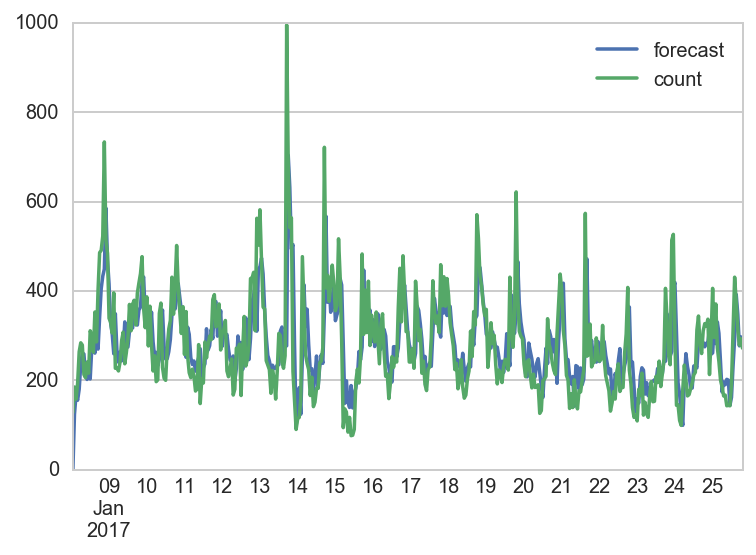

In [68]:
fig, ax = plt.subplots(figsize=(6,4))
fig = results_ARMA.plot_predict(start="2017-01-08 01:00", end="2017-01-25 19:00", ax=ax)
legend = ax.legend(loc='best')